In [1]:
import nd2
import numpy as np
from skimage.io import imsave,imread
import os
import subprocess
import h5py
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
from scipy.optimize import curve_fit
import shutil
from skimage import measure
from matplotlib.path import Path
import seaborn as sns

In [2]:
# nd2_dir = '/Users/zhengj10/Desktop/Test'
nd2_dir = '/Volumes/imaging/Abhi/T-GECO and GCaMP Oct 5 2022'
sum_dir = os.path.join(nd2_dir,'summary')
if not os.path.exists(sum_dir):
    os.makedirs(sum_dir)
    
save_dir = os.path.join(nd2_dir,'summary_221021')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
ilastik_location = '/Applications/ilastik-1.4.0b15-OSX.app/Contents/ilastik-release'
ilastik_project = '/Volumes/imaging/Abhi/ilastik/Ca_sensors.ilp'
os.chdir(ilastik_location)

### Image processing
- Create ref images for ilastik training (needed only once)
- Convert .nd files to .tif
- ROI segmentation with trained ilastik classifier
- Calculate parameters (dFF, kinetics, etc)

In [3]:
stim_onset = {
    '1AP':99-3,
    '3AP':501-3,
    '10AP':907-3,
    '20AP':1326-3,
    '160AP':1768-3
}

In [5]:
df = pd.read_pickle(sum_dir+'/Ca_sensor_screen.pkl')

In [6]:
df.shape
# df.columns

(2155, 13)

In [ ]:
plt.figure(figsize=[13,26])
sb = 1
df_sel = df[df['Stim']=='1AP']
for i,r in df_sel.iterrows():
    F = np.load(save_dir+'/%s_%s_raw_F_roi#%s.npy' %(r['Session'],r['Well'],r['ROI_#']))
    f0 = np.mean(F[10:20])
    fb = 400
    L = [0]
    if r['Session'] == 'GCaMP6s':
        for st in ['1AP','3AP']:
            L.append(stim_onset[st]-2)
    
    if r['Session'] == 'GCaMP8s':
        for st in ['1AP','3AP','10AP']:
            L.append(stim_onset[st]-2)
    else:
        for st in ['1AP','3AP','10AP','20AP','160AP']:
            L.append(stim_onset[st]-2)
    x = np.array(L)
    y = F[L]
    try:
        p,_ = curve_fit(lambda t,a,b,c:a*np.exp(b*t)+c,x,y,p0=(F[0]-F[L][-1],-0.02,F[L][-1]))
        x1 = np.arange(len(F))
        y1 = p[0]*np.exp(p[1]*x1)+p[2]
        if p[1]>0:
            p = np.array([0,0,0])
            F_c = F
            dff = (F_c-f0)/(f0-fb)
        else:
            F_c = F-y1+np.mean(F[10:20]) # bleach corrected trace
            dff = (F_c-f0)/(f0-fb)
    except:
        print('%s %s %s can not be fit with single exp curve' %(r['Session'],r['Well'],r['ROI_#']))
        p = np.array([0,0,0])
        F_c = F
        dff = (F_c-f0)/(f0-fb)
        
#     np.save(save_dir+'/%s_%s_Bleach_fit_roi#%s.npy' %(r['Session'],r['Well'],r['ROI_#']),p)
#     np.save(save_dir+'/%s_%s_dFF_roi#%s.npy' %(r['Session'],r['Well'],r['ROI_#']),dff)
    if i%500==0:
        print(i)
plt.tight_layout()

In [ ]:
df_s = df[(df['Session']=='GCaMP6s')&(df['Stim']=='1AP')]
plt.figure(figsize=[13,70])
sb = 1
for i,r in df_s.iterrows():
    F = np.load(sum_dir+'/%s_%s_raw_F_roi#%s.npy' %(r['Session'],r['Well'],r['ROI_#']))
    bl = np.load(save_dir+'/%s_%s_Bleach_fit_roi#%s.npy' %(r['Session'],r['Well'],r['ROI_#']))

    if bl.any()!=0:
        y = bl[0]*np.exp(bl[1]*x)+bl[2]
        x = np.arange(F.shape[0])
        ax = plt.subplot(20,3,sb)
        ax.plot(x,F)
        # plt.plot(x,r-y)
        ax.plot(x,y)
    #     plt.xlim([0,200])
        ax.set_title(r['Well']+'_%s' %(r['ROI_#']))
        sb+=1
#     except:
#         continue
    if sb>60:
        break

In [24]:
# bl.any()
df.shape

(2155, 13)

In [31]:
dFF = []
dFF_peak = []
F0 = []
Fb = []
T_peak = [] # Frame # at dFF trace peak - Frame # at stim onset
Half_rise = [] # Frame # at half dFF trace peak in the rise phase
Half_decay = [] # Frame # at half dFF trace peak in the decay phase
SNR = []
for i,r in df.iterrows():
    stim_start_idx = stim_onset[r['Stim']]
    dff = np.load(save_dir+'/%s_%s_dFF_roi#%s.npy' %(r['Session'],r['Well'],r['ROI_#']))
    if r['Stim']=='160AP':
        trace = dff[stim_start_idx:]
        trace = trace-trace[0]
    else:
        trace = dff[stim_start_idx:stim_start_idx+350]
        trace = trace-trace[0]
    dff_peak = np.max(trace)
    half_peak = dff_peak/2.0
    t_peak_idx = np.argmin(np.abs(trace - dff_peak))

    if r['Stim']=='160AP':
        dFF.append(dff[stim_start_idx-50:])
    else:
        dFF.append(dff[stim_start_idx-50:stim_start_idx+350])
    dFF_peak.append(dff_peak)

    F0.append(r['F0'])
    Fb.append(r['Fb'])
    SNR.append(dff_peak/np.std(dff[10:20]))
    T_peak.append((t_peak_idx+1)/33.0)

    rise_trace = trace[:t_peak_idx]
    try:
        half_rise_idx = np.argmin(np.abs(rise_trace-half_peak))
        Half_rise.append((half_rise_idx+1)/33.0)
    except:
        Half_rise.append(np.nan)

    if r['Stim'] == '160AP':
        decay_trace = trace[319:]
    else:
        decay_trace = trace[t_peak_idx:]
    try:
        half_decay_idx = np.argmin(np.abs(decay_trace-half_peak))
        Half_decay.append((half_decay_idx+1)/33.0)
    except:
        Half_decay.append(np.nan)
        continue
    if i%100==0:
        print(i)
plt.tight_layout()
plt.show()

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100


<Figure size 432x288 with 0 Axes>

In [27]:
# df_temp = pd.DataFrame()
# df_temp['S'] = S
# df_temp['HD'] = Half_decay
# T_peak
# t_peak_idx
# Half_decay

In [ ]:
sns.stripplot(x='S',y='HD',data=df_temp)

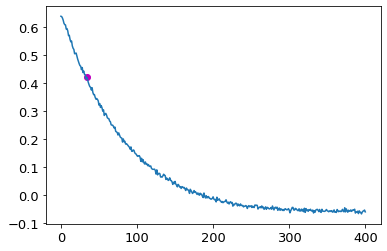

In [41]:
plt.plot(decay_trace)
plt.scatter(half_decay_idx,decay_trace[half_decay_idx],color='m')
# plt.close()

In [ ]:
# i
# r['Stim']
# plt.plot(dff)
# plt.plot(trace)
# r['Session']
# rise_trace.shape[0]
# stim_start_idx
# t_peak_idx

In [32]:
df_n = pd.DataFrame()
col = ['Session', 'Well', 'ROI_#', 'ROI_coordinates', 'Stim']
for c in col:
    df_n[c] = df[c]

In [33]:
df_n['dFF'] = dFF
df_n['dFF_peak'] = dFF_peak
df_n['F0'] = F0
df_n['Fb'] = Fb
df_n['SNR'] = SNR
df_n['Time to peak (s)'] = T_peak
df_n['Half rise time (s)'] = Half_rise
df_n['Half decay time (s)'] = Half_decay

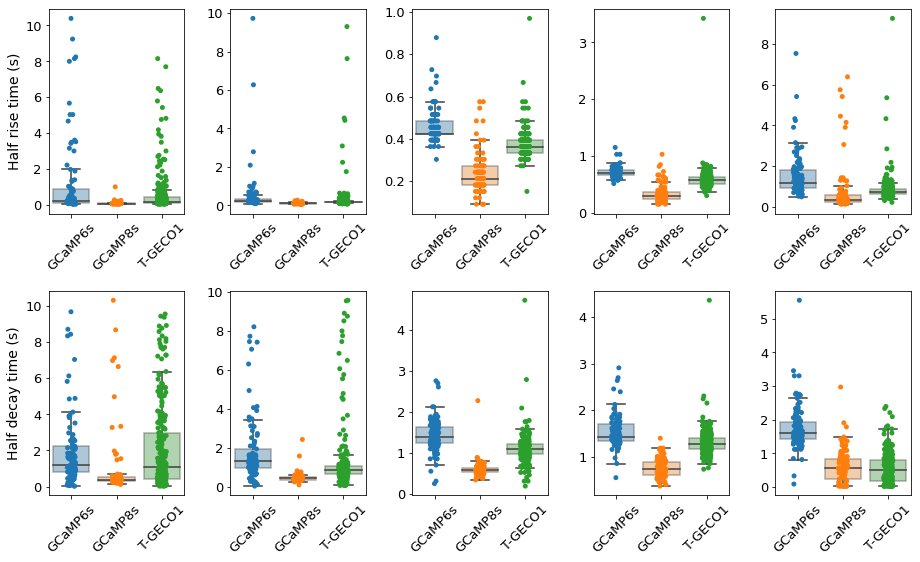

In [61]:
plt.figure(figsize=[13,8])
plt.rc('font',size=13)
sb = 1
for param in ['Half rise time (s)','Half decay time (s)']:
    for s in df_n.Stim.unique():
        df_p = df_n[(df_n['Stim']==s)]
        ax = plt.subplot(2,5,sb)
    #     sns.stripplot(x='Session',y='Half rise time (s)',data=df_p,ax=ax)
    #     sns.boxplot(x='Session',y='Half rise time (s)',data=df_p,ax=ax,boxprops=dict(alpha=0.4),showfliers=False)
        sns.stripplot(x='Session',y=param,data=df_p,ax=ax)
        sns.boxplot(x='Session',y=param,data=df_p,ax=ax,boxprops=dict(alpha=0.4),showfliers=False)
        if sb==1:
            ax.set_ylabel('Half rise time (s)',size=14)
    #         ax.set_ylabel('Half decay time (s)',size=14)
        elif sb==6:
            ax.set_ylabel('Half decay time (s)',size=14)
        else:
            ax.set_ylabel('')
        ax.set_xlabel('')
            
        sb+=1
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
#         ax.set_ylim([-0.3,4])
plt.tight_layout()
plt.savefig('/Users/zhengj10/Desktop/221025/Abhi_data/kinetics.png',dpi=1200)
plt.show()

In [42]:
df_n.to_pickle(save_dir+'/Ca_sensor_screen.pkl')
df_n.to_excel(save_dir+'/Ca_sensor_screen.xlsx')

In [43]:
df_dFF = pd.DataFrame()

In [44]:
df_dFF['Time (s)'] = np.arange(1,df_n.loc[0,'dFF'].shape[0]+1)/33.3
for i,r in df_n.iterrows():
    s = pd.Series(r['dFF'])
    df_dFF = pd.concat((df_dFF,s.rename(r['Session']+' '+r['Well']+' ROI#_'+str(r['ROI_#'])+' '+r['Stim'])),axis=1)

In [45]:
from itertools import zip_longest
df_dFF.columns = pd.MultiIndex.from_arrays(zip_longest(*df_dFF.columns.map(str.split), fillvalue=''))
df_dFF

Time   GCaMP6s                                                    \
         (s)       W01                                                     
                ROI#_1                                            ROI#_2   
                   1AP       3AP      10AP      20AP     160AP       1AP   
0    0.03003  0.033084 -0.007297  0.007088  0.024705  0.018799 -0.007066   
1    0.06006  0.018143  0.017335  0.019758  0.036415  0.029348 -0.006307   
2    0.09009  0.011934 -0.019210 -0.007903  0.016376  0.029399 -0.028985   
3    0.12012  0.018496  0.019354  0.000173  0.026724  0.039494 -0.007287   
4    0.15015  0.028945 -0.023248  0.011934  0.023645  0.015215 -0.004156   
..       ...       ...       ...       ...       ...       ...       ...   
765      NaN       NaN       NaN       NaN       NaN  0.017083       NaN   
766      NaN       NaN       NaN       NaN       NaN  0.046763       NaN   
767      NaN       NaN       NaN       NaN       NaN -0.001341       NaN   
768      NaN       NaN       NaN       NaN       NaN  0.043532       NaN   
769      NaN       NaN       NaN       NaN       NaN  0.025966       NaN   

                                   ...   T-GECO1                      \
                                   ...       W04                       
                                   ...   ROI#_59                       
          3AP      10AP      20AP  ...       1AP       3AP      10AP   
0   -0.005864 -0.004947  0.057458  ... -0.001575 -0.018481  0.000607   
1   -0.010893  0.002897  0.072070  ...  0.007978 -0.019996 -0.003917   
2   -0.010830 -0.008205  0.040599  ...  0.000100 -0.011644  0.000950   
3   -0.024209  0.002296  0.041516  ...  0.004526 -0.012525  0.007301   
4   -0.023228 -0.002290  0.074537  ...  0.002290 -0.012690  0.003518   
..        ...       ...       ...  ...       ...       ...       ...   
765       NaN       NaN       NaN  ...       NaN       NaN       NaN   
766       NaN       NaN       NaN  ...       NaN       NaN       NaN   
767       NaN       NaN       NaN  ...       NaN       NaN       NaN   
768       NaN       NaN       NaN  ...       NaN       NaN       NaN   
769       NaN       NaN       NaN  ...       NaN       NaN       NaN   

                                                                           
                                                                           
                          ROI#_60                                          
         20AP     160AP       1AP       3AP      10AP      20AP     160AP  
0    0.002436 -0.001376 -0.006159 -0.007712  0.000404 -0.000184  0.001384  
1    0.007224 -0.001838 -0.008309  0.006846 -0.002507 -0.000367  0.001812  
2    0.008580 -0.000259 -0.005229 -0.001107 -0.004401 -0.004628 -0.006942  
3    0.008149  0.006485  0.009204  0.005795  0.002670 -0.005866 -0.009627  
4    0.004578 -0.003605  0.004187  0.005018  0.004788  0.001607 -0.010186  
..        ...       ...       ...       ...       ...       ...       ...  
765       NaN -0.030254       NaN       NaN       NaN       NaN -0.044756  
766       NaN -0.042231       NaN       NaN       NaN       NaN -0.041413  
767       NaN -0.023280       NaN       NaN       NaN       NaN -0.040128  
768       NaN -0.029416       NaN       NaN       NaN       NaN -0.037467  
769       NaN -0.040836       NaN       NaN       NaN       NaN -0.043957  

[770 rows x 2156 columns]

In [46]:
df_dFF.to_excel('/Users/zhengj10/Desktop/Ca_sensor_screen_dFF_only.xlsx')

In [ ]:
df_p = df_n[(df_n['Session']=='GCaMP6s')&(df_n['Stim']=='160AP')]

In [ ]:
df_n.Stim.unique()

In [ ]:
plt.figure(figsize=[13,3.5])
plt.rc('font',size=13)
sb = 1
# for s in df_n.Stim.unique():
df_p = df_n[(df_n['Session']=='GCaMP6s')&(df_n['Stim']=='10AP')]
mean = np.nanmean(df_p.dFF.to_list(),axis=0)
sem = np.nanstd(df_p.dFF.to_list(),axis=0)/np.sqrt(len(df_p.dFF.to_list()))
x = np.arange(mean.shape[0])/33.0
# ax = plt.subplot(1,5,sb)
ax = plt.subplot(111)
ax.plot(x,mean,color='k',alpha=0.75)
ax.fill_between(x,mean+sem,mean-sem,color='k',alpha=0.25)
# ax.set_ylim([-0.1212950823416378, 2.62117312295992])
if sb==1:
    ax.set_ylabel('\u0394F/F0',size=14)
ax.set_xlabel('s',size=14)
sb+=1
plt.tight_layout()
plt.show()
# plt.plot(mean)

In [ ]:
df_ps = df_n[(df_n['Stim']=='1AP')]
ax = plt.subplot(111)
sns.stripplot(x='Session',y='Half rise time (ms)',data=df_ps,ax=ax)
# ax.set_ylim(-1,500)

In [ ]:
c = df_ps[df_ps['Half rise time (ms)']>8000]

In [ ]:
plt.plot(c.dFF.to_list()[0])

In [ ]:
# ax.get_ylim()
df_n.columns